In [1]:
import os
import pickle
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob
%matplotlib inline

In [2]:
# upload the calibration matrix

with open("calibration.p", mode='rb') as f:
    calib = pickle.load(f)
mtx = calib["mtx"]
dist = calib["dist"]

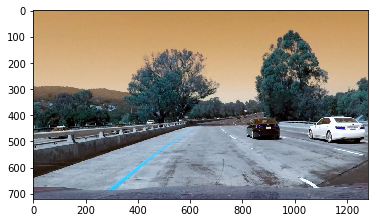

In [3]:
img = cv2.resize(cv2.imread('./test_images/test1.jpg'), (1280, 720))   #straight_lines1.jpg')

# undistort the image
imag_und=cv2.undistort(img, mtx, dist, None, mtx)

plt.imshow(img)

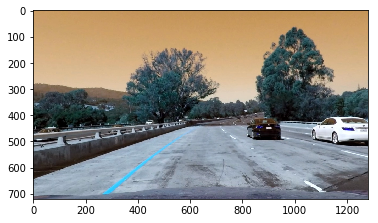

In [4]:
plt.imshow(imag_und)

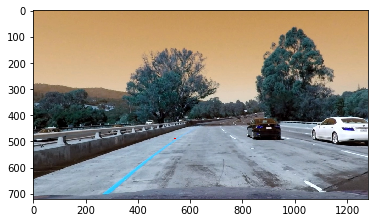

In [5]:
# used this to get the source points needed for warpPerspective 
i_ = cv2.circle(imag_und, (542, 490), radius=3, color=(255, 0, 0), thickness=-1)
plt.imshow(imag_und)

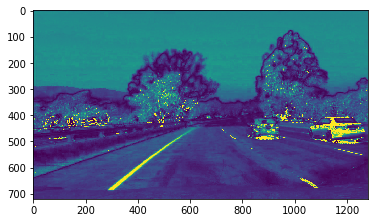

In [6]:
# used to test the hls channels
hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
h = hls[:,:,0]
l = hls[:,:,1]
s_chnl = hls[:,:,2]

plt.imshow(s_chnl)

In [7]:
def color_grad(imag, s_thresh=(100, 255), sx_thresh=(20, 100)):
    img = np.copy(imag)
    # Convert to HLS color space and separate the V channel
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]
    # Sobel x
    sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    
    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    # Stack each channel
    color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary)) * 255
    return color_binary

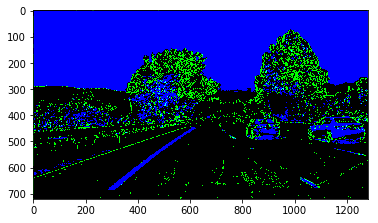

In [8]:
clr_grad = color_grad(img)
plt.imshow(clr_grad)

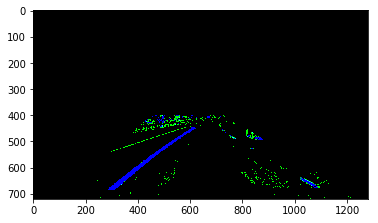

In [9]:
def ROI_1(img):
    mask_1 = np.zeros_like(img)
    mask_2 = np.zeros_like(img)   
    vertices_1 = np.array([[(100,720),(450, 400), (730, 400), (1250,720)]], dtype=np.int32)  #for c5.jpg # to hide outside the lanes
    vertices_2 = np.array([[(0, 720), (0,0), (1280, 0), (1280, 720), (900,720), (650,480),(500,720)]], dtype=np.int32) #for c5.jpg  # to hide inside the lane

    #vertices_1 = np.array([[(0, 720), (0,400), (1280,400), (1280, 720)]], dtype=np.int32)   # to hide outside the lanes
    #vertices_2 = np.array([[(0, 720), (0,0), (1280, 0), (1280, 720), (800,720), (600,600),(400,720)]], dtype=np.int32)  # to hide inside the lane

    #mask_2 = np.zeros_like(img)   
    #vertices_1 = np.array([[(200,720),(650, 400), (750, 400), (1100,720)]], dtype=np.int32)   # to hide outside the lanes
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    #cv2.fillPoly(mask, [vertices_1], ignore_mask_color)
    cv2.fillPoly(mask_1, [vertices_1], ignore_mask_color)
    cv2.fillPoly(mask_2, [vertices_2], ignore_mask_color)
    
    mask = cv2.bitwise_and(mask_1, mask_2)
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

 # 4 points to create the boundry

#masked = ROI(binary, v)
masked_1 = ROI_1(clr_grad)
plt.imshow(masked_1)

In [10]:
# apply the warpPerspective
def Transform(img, img_size, warp_dewarp='warp'):
    imag=cv2.undistort(img, mtx, dist, None, mtx)
    
    src = np.float32([(200, 720),         #lb
                    (542, 490),         #lt
                    (750, 490),         #rt
                    (1095, 720)])       #rb
    dst = np.float32([(300, 720),         #lb        it was (200, 720)
                    (300, 0),           #lt          it was (200, 0)
                    (995, 0),           #rt         it was (1095, 0)
                    (995, 720)])       #rb          it was (1095, 720)
    #wrap
    if warp_dewarp=='warp':
        M = cv2.getPerspectiveTransform(src, dst)
    #dewrap
    elif warp_dewarp=='dewarp':
        M = cv2.getPerspectiveTransform(dst, src)
    
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)
    return warped, M
    
    

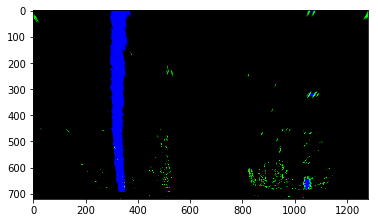

In [11]:
img_size = (img.shape[1], img.shape[0])
w, m = Transform(masked_1, img_size, warp_dewarp='warp')

plt.imshow(w)

In [12]:
# to test the Histogram
def hist(img):
    # Lane lines are likely to be mostly vertical nearest to the car
    y= img.shape[0]
    bottom_half=np.zeros_like(img)
    bottom_half[int(y/2)::1]= img[int(y/2):y:1]
    #plt.imshow(bottom_half)

    # apply Histogram
    histogram = np.sum(bottom_half, axis=0)
    
    return histogram

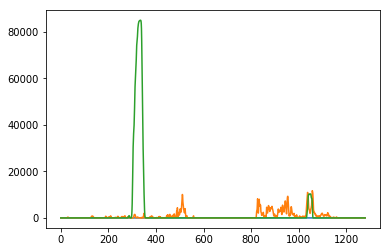

In [13]:
h= hist(w)
plt.plot(h)

In [14]:
def find_lane_pixels(binary_warped):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)   # instead of 600: binary_warped.shape[0]//2
    # Create an output image to draw on and visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # HYPERPARAMETERS
    # Choose the number of sliding windows
    nwindows = 9     #15
    # Set the width of the windows +/- margin
    margin = 100      #100
    # Set minimum number of pixels found to recenter window
    minpix = 50       #50

    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),
        (win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),
        (win_xright_high,win_y_high),(0,255,0), 2) 
        
        
        # Identify the nonzero pixels in x and y within the window #
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
                
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    return leftx, lefty, rightx, righty, out_img

previous_values = []
def fit_polynomial(binary_warped):
    global previous_values
    # Find our lane pixels first
    gray = cv2.cvtColor(binary_warped, cv2.COLOR_RGB2GRAY)
    leftx, lefty, rightx, righty, out_img = find_lane_pixels(gray)

    # to avoide error if lefty or leftx is nan
    if lefty.any() and leftx.any():
        left_fit = np.polyfit(lefty, leftx, 2)
    else:
        left_fit = previous_values[0]
    # to avoide error if righty or rightx is nan 
    if rightx.any() and righty.any():
        right_fit = np.polyfit(righty, rightx, 2)
    else:
        right_fit = previous_values[1] 

    
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty

    #print(previous_values)

    return out_img, left_fitx, right_fitx, left_fit, right_fit, ploty

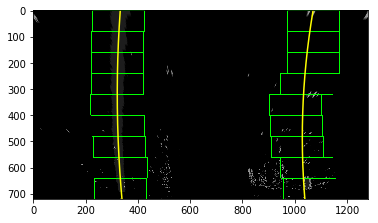

In [15]:


lane, left_fitx, right_fitx, left_fit, right_fit, ploty = fit_polynomial(w)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.imshow(lane)



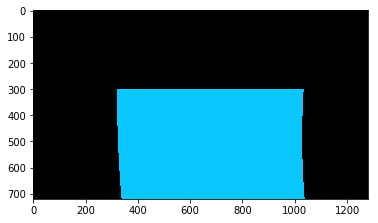

In [16]:

def draw(img, poly_coeffs, steps, color=[255, 0, 0], thickness=10, dashed=False):
    img_height = img.shape[0]
    pixels_per_step = img_height // steps

    for i in range(steps):
        start = i * pixels_per_step
        end = start + pixels_per_step

        start_point = (int(poly_coeffs[0]*start**2 + poly_coeffs[1]*start + poly_coeffs[2]), start)
        end_point = (int(poly_coeffs[0]*end**2 + poly_coeffs[1]*end + poly_coeffs[2]), end)

        if dashed == False or i % 2 == 1:
            img = cv2.line(img, end_point, start_point, color, thickness)
    return img


def fill_between(lane, left_poly, right_poly, start_y=300, end_y =720):
    
    empty = np.zeros_like(lane[:,:,0])    #np.zeros((720, 1280))   #mask_template
    colour = cv2.cvtColor(empty.astype(np.uint8), cv2.COLOR_GRAY2RGB)

    polyfit_left = draw(empty, left_fit, 30)
    polyfit_drawn = draw(polyfit_left, right_fit, 30)

    filled = colour    
    mask = empty
    
    for y in range(start_y, end_y):
        left = left_poly[0]*y**2 + left_poly[1]*y + left_poly[2]
        right = right_poly[0]*y**2 + right_poly[1]*y + right_poly[2]
        mask[y][int(left):int(right)] = 1
    
    filled[mask == 1] = [10,200,255]

    return filled


filled_img = fill_between(lane, left_fit, right_fit)
plt.imshow(filled_img)

In [17]:
# get the poition and curvature:

In [18]:
def measure_curvature_pixels(left_fitx, right_fitx, left_fit, right_fit, ploty):
    '''
    Calculates the curvature of polynomial functions in pixels.
    '''    
    # Define y-value where we want radius of curvature
    # We'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval = np.max(ploty)
    m_per_pxl= [3.7/700, 22/720]   #[x, y]
    
    left_fit_cr = np.polyfit(ploty*m_per_pxl[1], left_fitx*m_per_pxl[0], 2)
    right_fit_cr = np.polyfit(ploty*m_per_pxl[1], right_fitx*m_per_pxl[0], 2)
    
    # Calculation of R_curve (radius of curvature) in pixels
    left_curverad = ((1 + (2*left_fit_cr[0]*m_per_pxl[1] + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*m_per_pxl[1] + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*m_per_pxl[1] + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*m_per_pxl[1] + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    
    
    return left_curverad, right_curverad

# Calculate the radius of curvature in pixels for both lane lines
left_curverad, right_curverad = measure_curvature_pixels(left_fitx, right_fitx, left_fit, right_fit, ploty)
print("the left curve rad={},\tthe right curve rad={}".format(left_curverad, right_curverad))

the left curve rad=787.9959254012052,	the right curve rad=503.94281211495866


In [19]:
def car_position(binary_warped, left_fit, right_fit):
    m_per_pxl= [3.7/700, 22/720]   #[x, y]
    
    # Calculate the positions at the left and the right lines 
    left_x_pos = left_fit[0]*binary_warped.shape[0]**2 + left_fit[1]*binary_warped.shape[0] + left_fit[2]
    right_x_pos = right_fit[0]*binary_warped.shape[0]**2 + right_fit[1]*binary_warped.shape[0] + right_fit[2] 

    center_lanes_x_pos = (left_x_pos + right_x_pos)/2
    # Calculate the deviation between the center of the lane and the center of the picture
    veh_pos = ((binary_warped.shape[1]/2) - center_lanes_x_pos) * m_per_pxl[0] 
    return veh_pos

# get the car position/offset regarding the center
pos = car_position(filled_img, left_fit, right_fit)
print(pos)

-0.258734225912


In [20]:
# dewarp the image
img_size = (filled_img.shape[1], filled_img.shape[0])
dew, m = Transform(filled_img, img_size, warp_dewarp='dewarp')

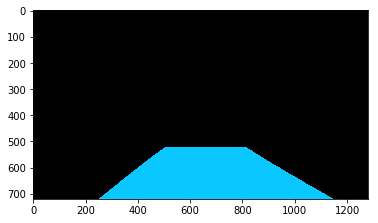

In [21]:
plt.imshow(dew)

In [22]:
combined = cv2.addWeighted(dew, 0.5, imag_und, 1., 0.)

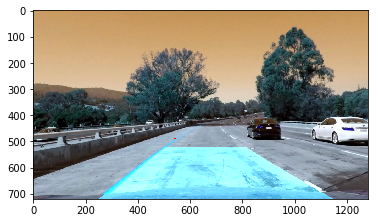

In [23]:
plt.imshow(combined)

In [24]:
previous_values = []

def lane_pipeline(image_):
    global previous_values
    
    # load the calibration matrix
    with open("calibration.p", mode='rb') as f:
        calib = pickle.load(f)
        mtx = calib["mtx"]
        dist = calib["dist"]
    
    # resize the image
    image = cv2.resize(image_, (1280, 720))   #straight_lines1.jpg')

    #undistort img and warp it
    undistorted=cv2.undistort(image, mtx, dist, None, mtx)
    
    # apply color and gradient to get the edges
    edges = color_grad(undistorted)
    
    # get the ROI from the image
    masked_1 = ROI_1(edges)
    
    img_size = (image.shape[1], image.shape[0])
    masked, m = Transform(masked_1, img_size, warp_dewarp='warp')
    
    # get the lanes
    lane, left_fitx, right_fitx, left_fit, right_fit, ploty = fit_polynomial(masked)
    previous_values = [left_fit, right_fit]
    # fill in between the lanes
    filled_img = fill_between(lane, left_fit, right_fit)
    
    # calculate the road's curvature and car's position
    left_curverad, right_curverad = measure_curvature_pixels(left_fitx, right_fitx, left_fit, right_fit, ploty)
    pos = car_position(masked, left_fit, right_fit)
    
    cv2.putText(undistorted,'Radius in m: '+str((left_curverad+right_curverad)/2)[:7],(40,70), cv2.FONT_HERSHEY_COMPLEX_SMALL, 1.6, (255,0,0),2,cv2.LINE_AA)
    cv2.putText(undistorted,'Offset in m: '+str(pos)[:7],(40,150), cv2.FONT_HERSHEY_COMPLEX_SMALL, 1.6,(255,0,0),2,cv2.LINE_AA)
    
    
    # dewarp the image
    img_size = (filled_img.shape[1], filled_img.shape[0])
    dew, m = Transform(filled_img, img_size, warp_dewarp='dewarp')
    
    # combine the lanes with the original image
    combined = cv2.addWeighted(dew, 0.5, undistorted, 1., 0.)
    
    return combined


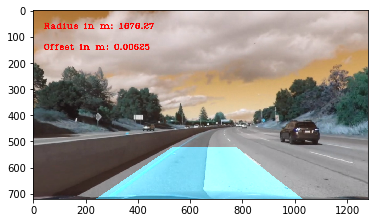

In [25]:
# test the pipeline on a test image

img_ = cv2.imread('./test_images/c1.jpg')    #test1, 4, 6
lane = lane_pipeline(img_)

plt.imshow(lane)

In [26]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

previous_values = []
def process(img):
    global previous_values
    output = lane_pipeline(img)
    
    return output

In [27]:
white_output = 'output_video/project_video.mp4'

# project_video
#challenge_video

clip1 = VideoFileClip("project_video.mp4") #.subclip(0,5)
#clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(process) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video output_video/project_video.mp4
[MoviePy] Writing video output_video/project_video.mp4


100%|█████████▉| 1260/1261 [05:25<00:00,  3.88it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_video/project_video.mp4 

CPU times: user 2min 58s, sys: 17.9 s, total: 3min 16s
Wall time: 5min 28s


In [28]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

################     HINT   #############################
#  when the offset is minus = the car on the left side  #
########################################################